In [5]:
coeff1 = np.loadtxt('coeff1.txt')
coeff0 = np.loadtxt('coeff0.txt')
tlist = np.loadtxt('tlist.txt')

In [21]:
tlist[1]

1.7064452899803988e-10

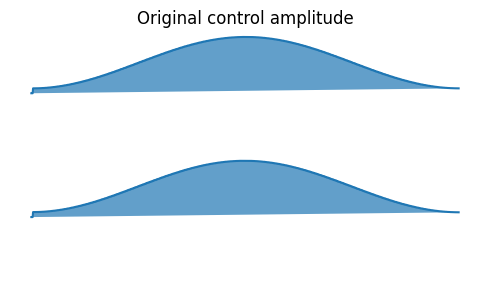

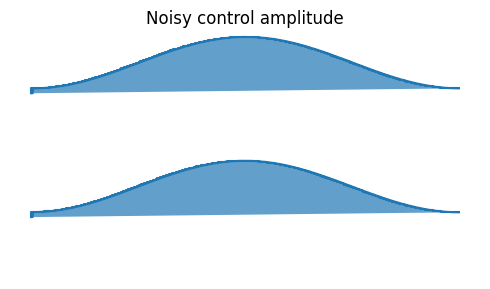

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import sigmaz, sigmay
from qutip.qip.device import Processor
from qutip.qip.noise import RandomNoise

# add control Hamiltonians
processor = Processor(N=1)
processor.add_control(sigmay(), targets=0)
processor.add_control(sigmaz(), targets=0)


# define pulse coefficients and tlist for all pulses
processor.pulses[0].coeff = coeff0
processor.pulses[1].coeff = coeff1
processor.set_all_tlist(tlist)

# define noise, loc and scale are keyword arguments for np.random.normal
gaussnoise = RandomNoise(dt=tlist[1], indices = [0,1], rand_gen=np.random.normal, loc=0.00, scale=0.3)
processor.add_noise(gaussnoise)

# Plot the ideal pulse
fig1, axis1 = processor.plot_pulses(title="Original control amplitude", figsize=(5,3))

# Plot the noisy pulse
qobjevo, _ = processor.get_qobjevo(noisy=True)
noisy_coeff0 = qobjevo.to_list()[1][1] + qobjevo.to_list()[2][1]
noisy_coeff1 = qobjevo.to_list()[3][1] + qobjevo.to_list()[4][1]
fig2, axis2 = processor.plot_pulses(title="Noisy control amplitude", figsize=(5,3))
axis2[0].step(qobjevo.tlist, noisy_coeff0)
axis2[1].step(qobjevo.tlist, noisy_coeff1)

In [52]:
a,b = processor.get_qobjevo(noisy=True)

In [69]:
qobjevo.to_list()[3]

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]],
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
      

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import sigmaz, sigmay
from qutip.qip.device import Processor
from qutip.qip.noise import RandomNoise
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip.qip.operations import *

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *

import qutip_qip
from qutip_qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip_qip.noise import Noise
from qutip.qip.noise import RandomNoise # for Gaussian noise
from qutip.qip.pulse import Pulse
from qutip.qip.gates import *

from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import functools # for reduce
from joblib import Parallel, delayed  # for parallel simulations
import itertools # for RB inverse search

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_16756\2620752684.py:24: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import *


In [32]:
with open("rename.py") as f:
    exec(f.read())

In [22]:
class MyProcessor(ModelProcessor):
    """
    Custom processor built using ModelProcessor as the base class.
    This custom processor will inherit all the methods of the base class
    such as setting up of the T1 and T2 decoherence rates in the simulations.

    In addition, it is possible to write your own functions to add control
    pulses.

    Args:
        num_qubits (int): Number of qubits in the processor.
        t1, t2 (float or list): The T1 and T2 decoherence rates for the
    """

    def __init__(self, num_qubits, t1=None, t2=None):
        # call the parent class initializer
        super(MyProcessor, self).__init__(num_qubits, t1=t1, t2=t2)  
        # The control pulse is discrete or continous.
        self.pulse_mode = "discrete"
        # The dimension of each controllable quantum system
        self.model.dims = [2] * num_qubits
        self.num_qubits = num_qubits
        self.set_up_ops()  # set up the available Hamiltonians

    def set_up_ops(self):
        """
        Sets up the control operators.
        """
        # sigmax pulse on m-th qubit with the corresponding pulse
        for m in range(self.num_qubits):
            self.add_control(2 * np.pi * sigmax(), m, label="sx" + str(m))
        # sy
        for m in range(self.num_qubits):
            self.add_control(2 * np.pi * sigmay(), m, label="sy" + str(m))


In [35]:
# add control Hamiltonians
processor = MyProcessor(N=1)
processor.add_control(sigmaz(), targets=0)

# define pulse coefficients and tlist for all pulses
processor.pulses[0].coeff = np.array([0.3, 0.5, 0. ])
processor.set_all_tlist(np.array([0., np.pi/2., 2*np.pi/2, 3*np.pi/2]))

# define noise, loc and scale are keyword arguments for np.random.normal
gaussnoise = RandomNoise(dt=0.01, rand_gen=np.random.normal, loc=0.00, scale=0.3)
processor.add_noise(gaussnoise)

# Plot the ideal pulse
fig1, axis1 = processor.plot_pulses(title="Original control amplitude", figsize=(5,3))

# Plot the noisy pulse
qobjevo, _ = processor.get_qobjevo(noisy=True)
noisy_coeff = qobjevo.to_list()[1][1] + qobjevo.to_list()[2][1]
fig2, axis2 = processor.plot_pulses(title="Noisy control amplitude", figsize=(5,3))
axis2[0].step(qobjevo.tlist, noisy_coeff)

TypeError: MyProcessor.__init__() got an unexpected keyword argument 'N'

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import sigmaz, sigmay
from qutip.qip.device import Processor
from qutip.qip.noise import RandomNoise

# add control Hamiltonians
processor = Processor(N=1)
processor.add_control(sigmaz(), targets=0)

# define pulse coefficients and tlist for all pulses
processor.pulses[0].coeff = np.array([0.3, 0.5, 0. ])
processor.set_all_tlist(np.array([0., np.pi/2., 2*np.pi/2, 3*np.pi/2]))

# define noise, loc and scale are keyword arguments for np.random.normal
gaussnoise = RandomNoise(dt=0.01, rand_gen=np.random.normal, loc=0.00, scale=0.02)
processor.add_noise(gaussnoise)

# Plot the ideal pulse
fig1, axis1 = processor.plot_pulses(title="Original control amplitude", figsize=(5,3))

# Plot the noisy pulse
qobjevo, _ = processor.get_qobjevo(noisy=True)
noisy_coeff = qobjevo.to_list()[1][1] + qobjevo.to_list()[2][1]
fig2, axis2 = processor.plot_pulses(title="Noisy control amplitude", figsize=(5,3))
axis2[0].step(qobjevo.tlist, noisy_coeff)

TypeError: 'NoneType' object is not subscriptable

<Figure size 500x300 with 0 Axes>

In [46]:
processor.pulses

In [ ]:
[docs]class Noise(object):
    """
    The base class representing noise in a processor.
    The noise object can be added to :class:`.Processor` and
    contributes to evolution.
    """
    def __init__(self):
        pass

[docs]    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        """
        Return a pulses list added with noise and
        the pulse independent noise in a dummy Pulse object.

        Parameters
        ----------
        dims: list, optional
            The dimension of the components system, the default value is
            [2,2...,2] for qubits system.

        pulses: list of :class:`.Pulse`
            The input pulses, on which the noise object is to be applied.

        systematic_noise: :class:`.Pulse`
            The dummy pulse with no ideal control element.

        Returns
        -------
        noisy_pulses: list of :class:`.Pulse`
            Noisy pulses.

        systematic_noise: :class:`.Pulse`
            The dummy pulse representing pulse independent noise.
        """
        raise NotImplementedError(
            "Subclass error needs a method"
            "`get_noisy_dynamics` to process the noise.")


    def _apply_noise(self, pulses=None, systematic_noise=None, dims=None):
        """
        For backward compatibility, in case the method has no return value
        or only return the pulse.
        """
        result = self.get_noisy_dynamics(
            pulses=pulses, systematic_noise=systematic_noise, dims=dims)
        if result is None:  # in-place change
            pass
        elif isinstance(result, tuple) and len(result) == 2:
            pulses, systematic_noise = result
        # only pulse
        elif isinstance(result, list) and len(result) == len(pulses):
            pulses = result
        else:
            raise TypeError(
                "Returned value of get_noisy_dynamics not understood.")
        return pulses, systematic_noise


In [42]:
class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
        }

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
            (Note: Instruction class includes args:
                tlist (array): A list of times for the evolution.
                coeff (array): An array of coefficients for the gate pulses
            )

        """

        # Rotation angle
        phiNaught = gate.arg_value[1]
        
        # Parameters
        V = VNaught + np.random.normal(scale=VStd)
        phi = phiNaught + np.random.normal(scale=phaseStd)
        I = np.cos(phi)
        Q = np.sin(phi)

        # Find tlist (list of time steps) for pi pulse or pi-half pulse
        ratio_of_pi_pulse = gate.arg_value[0]
        if ratio_of_pi_pulse == 0.5:
            n_steps = int(samplingRate * (pi_pulse_duration/2 - t_0))
            tlist = np.linspace(t_0, pi_pulse_duration/2, n_steps) 
        else:
            n_steps = int(samplingRate * (pi_pulse_duration - t_0))
            tlist = np.linspace(t_0, pi_pulse_duration, n_steps)        

        # Find coeff for sigma x and sigma y (from Hamiltonian)
        dwt = np.random.normal(scale=detuningStd) * tlist
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * tlist / pi_pulse_duration)

        coeff_x = np.sign(gate.arg_value[1])*np.asarray([omega * np.pi * V * s[i] * (-I * np.cos(dwt[i]) + Q * np.sin(dwt[i])) for i in range(len(s))])
        coeff_y = np.sign(gate.arg_value[1])*np.asarray([omega * np.pi * V * s[i] * (I * np.sin(dwt[i]) - Q * np.cos(dwt[i])) for i in range(len(s))])

        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), coeff_x),
            ("sy" + str(gate.targets[0]), coeff_y),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

In [59]:
num_qubits = 1

circuit = QubitCircuit(num_qubits)
circuit.add_gate("RY", targets=0, arg_value=[0.5,-np.pi])
circuit.add_gate("RX", targets=0, arg_value=[0.5,-np.pi])

myprocessor = MyProcessor(num_qubits)
myprocessor.native_gates = ["RX", "RY"]

init_state = basis(2, 0)
mycompiler = MyCompiler(num_qubits,{})

gaussnoise = MyRandomNoise(dt=0.01, rand_gen=np.random.normal, loc=0.00, scale=0.3)
myprocessor.add_noise(gaussnoise)  # The noise is added to the processor

TypeError: object.__init__() takes exactly one argument (the instance to initialize)

In [44]:
myprocessor.pulses

[]